In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from itertools import *
from sklearn.cluster import KMeans
import os

In [2]:
def show(image, cmap='gray'):
    plt.imshow(image, cmap=cmap)
    plt.show()
    
def export(imagename):
    cv2.imwrite(imagename+".jpg", eval(imagename))
    
kernel = np.ones((7,7),np.uint8)
kernel_bigger = np.ones((50,50),np.uint8)
kernel_even_bigger = np.ones((5,900),np.uint8)

padding_size = 10

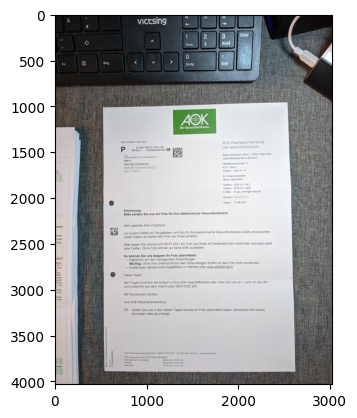

In [3]:
input_folder = "input"
output_folder = "output"

file_name = "DOC_03"
file_extension = ".jpg"

img00 = cv2.imread(os.path.join("input", file_name + file_extension))
show(img00)

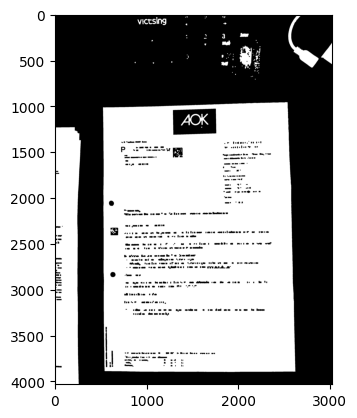

In [4]:
img01 = cv2.cvtColor(img00, cv2.COLOR_BGR2GRAY)
ret,img01 = cv2.threshold(img01, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
img01 = cv2.morphologyEx(img01, cv2.MORPH_OPEN, kernel)
img01 = cv2.morphologyEx(img01, cv2.MORPH_CLOSE, kernel)
show(img01)

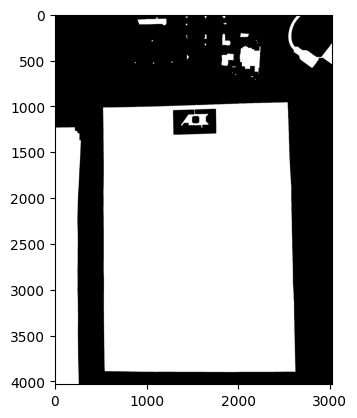

In [5]:
img02 = cv2.morphologyEx(img01, cv2.MORPH_CLOSE, kernel_bigger)
show(img02)

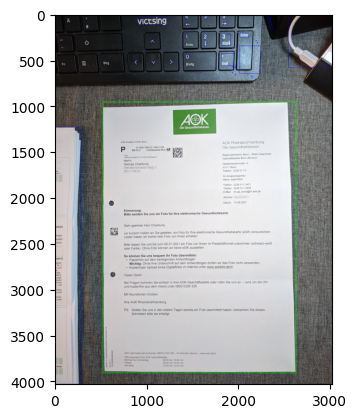

In [6]:
img03 = img00.copy()
bounding_boxes = list()

contours = cv2.findContours(img02, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for c in contours[0]:
    x,y,w,h = cv2.boundingRect(c)
    bounding_boxes.append(np.array([x, y, x+w, y+h, w*h]))
    cv2.rectangle(img03, (x, y), (x + w, y + h), (0,0,255), 2)
    
bb_index = np.argmax(np.array(bounding_boxes)[:,4])
bb = bounding_boxes[bb_index]

cv2.rectangle(img03, (bb[0], bb[1]), (bb[2], bb[3]), (0,255,0), 2)

bbwp = bb[:4].copy()
bbwp[0] = bbwp[0] - padding_size
bbwp[1] = bbwp[1] - padding_size
bbwp[2] = bbwp[2] + padding_size
bbwp[3] = bbwp[3] + padding_size

cv2.rectangle(img03, (bbwp[0], bbwp[1]), (bbwp[2], bbwp[3]), (0,255,0), 2)
    
show(img03)

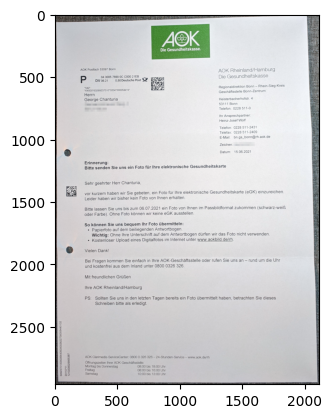

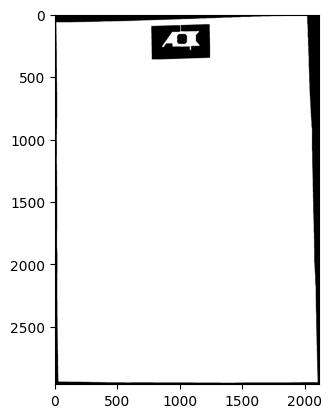

In [7]:
img04 = img00[bbwp[1]:bbwp[3], bbwp[0]:bbwp[2]]
img05 = img02[bbwp[1]:bbwp[3], bbwp[0]:bbwp[2]]
img05 = cv2.morphologyEx(img05, cv2.MORPH_CLOSE, kernel)
show(img04)
show(img05)

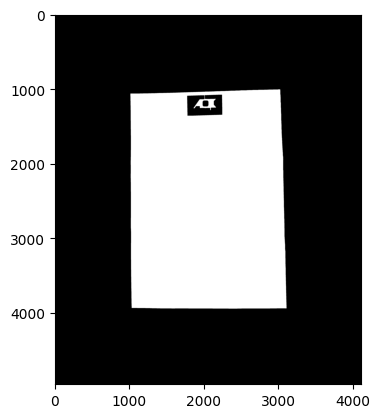

In [8]:
bigger_padding = 1000

img05_more_padding = np.zeros((img05.shape[0] + 2*bigger_padding, img05.shape[1] + 2*bigger_padding), dtype=np.uint8)
img05_more_padding[bigger_padding:bigger_padding+img05.shape[0], bigger_padding:bigger_padding+img05.shape[1]] = img05

show(img05_more_padding)

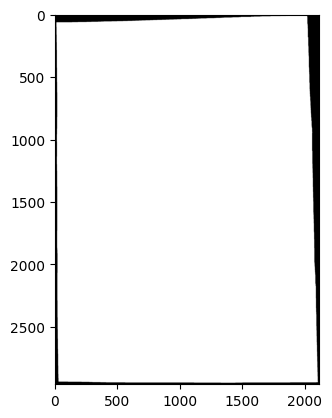

In [9]:
img05_clean = cv2.morphologyEx(img05_more_padding, cv2.MORPH_CLOSE, kernel_even_bigger)[bigger_padding:bigger_padding+img05.shape[0], bigger_padding:bigger_padding+img05.shape[1]]

show(img05_clean)

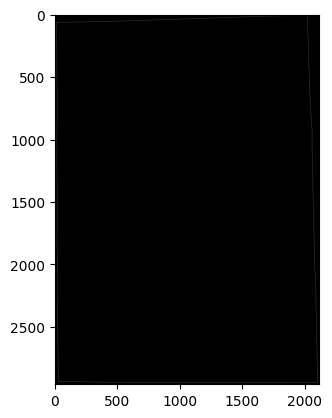

In [10]:
img06 = cv2.Canny(img05_clean, 127, 255)
show(img06)

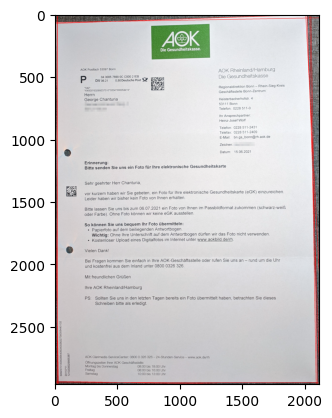

In [11]:
img07 = img04.copy()

lines = cv2.HoughLines(img06,1,np.pi/180,200)
for line in lines:
    rho, theta = line[0]
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    n = 5000
    x1 = int(x0 + n * (-b))
    y1 = int(y0 + n * (a))
    x2 = int(x0 - n * (-b))
    y2 = int(y0 - n * (a))

    cv2.line(
        img07, 
        (x1, y1), 
        (x2, y2), 
        (255, 0, 0), 
        2
    )

show(img07)

In [12]:
intersection_points = list()

for i,j in combinations(range(len(lines)),2):
    rho1, theta1 = lines[i][0]
    rho2, theta2 = lines[j][0]

    angle_between = np.abs(int(np.degrees(theta1 - theta2)))
    almost_right_angle = 80.0 < angle_between < 100.0

    if not almost_right_angle:
        continue
    
    A = np.array([
      [np.cos(theta1), np.sin(theta1)],
      [np.cos(theta2), np.sin(theta2)]
    ])
    
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.array(np.linalg.solve(A, b), dtype=np.int16).flatten()
    
    if x0 < 0 or x0 > img07.shape[1] or y0 < 0 or y0 > img07.shape[0]:
        continue
    
    intersection_points.append(np.array([x0, y0]))
    
intersection_points = np.array(intersection_points)

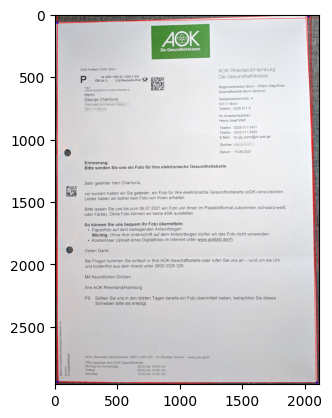

In [13]:
kmeans = KMeans(n_clusters = 4, 
                init = 'k-means++', 
                max_iter = 100, 
                n_init = 10, 
                random_state = 0).fit(intersection_points)
corners = kmeans.cluster_centers_

img08 = img07.copy()
for corner in corners:
    x, y = corner
    cv2.circle(img08, (int(x), int(y)), 5, (0, 0, 255), 5)
    
show(img08)

In [14]:
a4_300_dpi_width = 2480
a4_300_dpi_height = 3508

output_corners = np.array([
    [0, 0],
    [a4_300_dpi_width, 0],
    [a4_300_dpi_width, a4_300_dpi_height],
    [0, a4_300_dpi_height]
])

output_corners_matched = output_corners.copy()
output_corners_distance = np.linalg.norm(output_corners_matched - corners)

for p in permutations(output_corners, 4):
    d = np.linalg.norm(p - corners)
    if d < output_corners_distance:
        output_corners_matched = p
        output_corners_distance = d

In [15]:
np.float32(corners)

array([[2028.  ,   17.25],
       [  21.  , 2942.5 ],
       [  18.  ,   70.  ],
       [2094.5 , 2947.  ]], dtype=float32)

In [16]:
np.float32(output_corners_matched)

array([[2480.,    0.],
       [   0., 3508.],
       [   0.,    0.],
       [2480., 3508.]], dtype=float32)

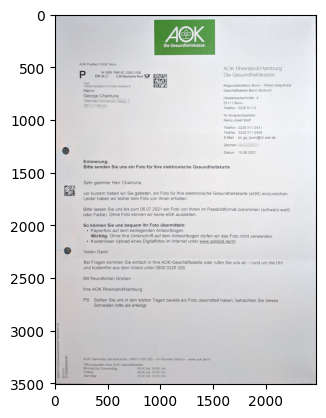

In [17]:
persp_tr = cv2.getPerspectiveTransform(np.float32(corners), np.float32(output_corners_matched))
img09 = cv2.warpPerspective(img04, persp_tr, (a4_300_dpi_width, a4_300_dpi_height))

show(img09)

In [18]:
save_intermediate_steps = True

if save_intermediate_steps:
    intermediate_folder = "intermediate"

    cv2.imwrite(os.path.join(intermediate_folder, file_name + "_00" + file_extension), img00)
    cv2.imwrite(os.path.join(intermediate_folder, file_name + "_01" + file_extension), img01)
    cv2.imwrite(os.path.join(intermediate_folder, file_name + "_02" + file_extension), img02)
    cv2.imwrite(os.path.join(intermediate_folder, file_name + "_03" + file_extension), img03)
    cv2.imwrite(os.path.join(intermediate_folder, file_name + "_04" + file_extension), img04)
    cv2.imwrite(os.path.join(intermediate_folder, file_name + "_05" + file_extension), img05)
    cv2.imwrite(os.path.join(intermediate_folder, file_name + "_05_bigger" + file_extension), img05_more_padding)
    cv2.imwrite(os.path.join(intermediate_folder, file_name + "_05_clean" + file_extension), img05_clean)
    cv2.imwrite(os.path.join(intermediate_folder, file_name + "_06" + file_extension), img06)
    cv2.imwrite(os.path.join(intermediate_folder, file_name + "_07" + file_extension), img07)
    cv2.imwrite(os.path.join(intermediate_folder, file_name + "_08" + file_extension), img08)
    cv2.imwrite(os.path.join(intermediate_folder, file_name + "_09" + file_extension), img09)

cv2.imwrite(os.path.join(output_folder, file_name + "_CROPPED" + file_extension), img09)

print("That's all, folks!")

That's all, folks!
